    Import library and get datas:

In [15]:
import pandas_datareader as pdr
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

aapl = pdr.get_data_yahoo('AAPL',start=datetime.datetime(2015, 1, 1),end=datetime.datetime(2017, 1, 1))

In [16]:
# Initialize the short and long windows
short_window = 40
long_window = 100

# Initialize the 'signals' DataFrame with the 'signal' column
signals = pd.DataFrame(index=aapl.index)
signals['signal'] = 0.0

# Create short simple moving average over the short window
signals['short_mavg'] = aapl['Close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = aapl['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

# Print 'signals'
print(signals)

            signal  short_mavg   long_mavg  positions
Date                                                 
2014-12-31     0.0  110.379997  110.379997        NaN
2015-01-02     0.0  109.855000  109.855000        0.0
2015-01-05     0.0  108.653333  108.653333        0.0
2015-01-06     0.0  108.055000  108.055000        0.0
2015-01-07     0.0  107.994000  107.994000        0.0
2015-01-08     0.0  108.643333  108.643333        0.0
2015-01-09     0.0  109.124286  109.124286        0.0
2015-01-12     0.0  109.140000  109.140000        0.0
2015-01-13     0.0  109.260000  109.260000        0.0
2015-01-14     0.0  109.314001  109.314001        0.0
2015-01-15     0.0  109.087273  109.087273        0.0
2015-01-16     0.0  108.829167  108.829167        0.0
2015-01-20     0.0  108.820770  108.820770        0.0
2015-01-21     0.0  108.872858  108.872858        0.0
2015-01-22     0.0  109.108001  109.108001        0.0
2015-01-23     0.0  109.350001  109.350001        0.0
2015-01-26     0.0  109.5705

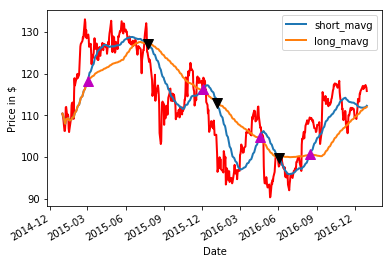

In [17]:
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, ylabel='Price in $')

# Plot the closing price
aapl['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')
         
# Show the plot
plt.show()

     initial capital = 100000$:

In [18]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame 'positions'
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['AAPL'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(aapl['Adj Close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add 'holdings' to portfolio
portfolio['holdings'] = (positions.multiply(aapl['Adj Close'], axis=0)).sum(axis=1)

# Add 'cash' to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(aapl['Adj Close'], axis=0)).sum(axis=1).cumsum()   

# Add 'total' to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add 'returns' to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print all of the lines of 'portfolio'
print(portfolio)

                  AAPL    holdings         cash        total   returns
Date                                                                  
2014-12-31      0.0000      0.0000          NaN          NaN       NaN
2015-01-02      0.0000      0.0000  100000.0000  100000.0000       NaN
2015-01-05      0.0000      0.0000  100000.0000  100000.0000  0.000000
2015-01-06      0.0000      0.0000  100000.0000  100000.0000  0.000000
2015-01-07      0.0000      0.0000  100000.0000  100000.0000  0.000000
2015-01-08      0.0000      0.0000  100000.0000  100000.0000  0.000000
2015-01-09      0.0000      0.0000  100000.0000  100000.0000  0.000000
2015-01-12      0.0000      0.0000  100000.0000  100000.0000  0.000000
2015-01-13      0.0000      0.0000  100000.0000  100000.0000  0.000000
2015-01-14      0.0000      0.0000  100000.0000  100000.0000  0.000000
2015-01-15      0.0000      0.0000  100000.0000  100000.0000  0.000000
2015-01-16      0.0000      0.0000  100000.0000  100000.0000  0.000000
2015-0

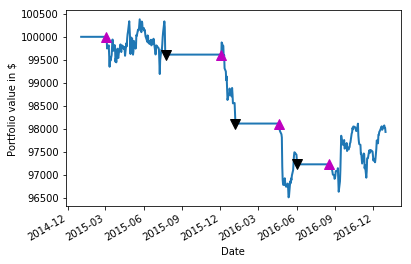

In [19]:
# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

In [20]:
# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)

-0.618454250715


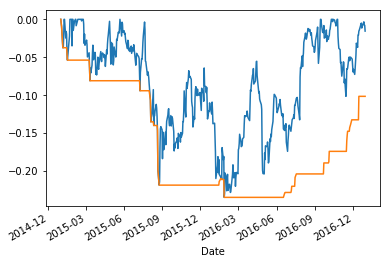

In [22]:
# Define a trailing 100 trading day window
window = 100

# Calculate the max drawdown in the past window days for each day 
rolling_max = aapl['Adj Close'].rolling(window, min_periods=1).max()
daily_drawdown = aapl['Adj Close']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()

# Show the plot
plt.show()

       Compound annual growth rate:

In [23]:
# Get the number of days in 'aapl'
days = (aapl.index[-1] - aapl.index[0]).days

# Calculate the CAGR - compound
cagr = ((((aapl['Adj Close'][-1]) / aapl['Adj Close'][1])) ** (365.0/days)) - 1

# Print the CAGR
print(cagr)

0.0494678955958
